In [311]:
# import neccessary packages.
import pandas as pd 
import numpy as np   
import matplotlib.pyplot  as plt  
import seaborn as sns  
import scipy.stats as stats
from scipy.stats import loguniform
import plotly.express as px   
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,StackingRegressor,HistGradientBoostingRegressor,VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,cross_val_score
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_error 


#### Import Dataframes 

In [250]:
train_data=pd.read_csv("/Users/hp/Desktop/Data Science/prj/house-prices-advanced-regression-techniques(1)/train.csv")
test_data=pd.read_csv("/Users/hp/Desktop/Data Science/prj/house-prices-advanced-regression-techniques(1)/test.csv") 
sample_sum=pd.read_csv("/Users/hp/Desktop/Data Science/prj/house-prices-advanced-regression-techniques(1)/sample_submission.csv")

### Observe shape of the data.

In [251]:
print(f"Training data shape:",train_data.shape)
print(f"Test data shape:",test_data.shape)

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [252]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [253]:
def missing_values(df):
    column=list()
    missing_num=list()
    missing_per=list()
    data_type=list()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            column.append(col) 
            missing_num.append(df[col].isna().sum())
            missing_per.append((df[col].isna().sum() / len(df)) * 100)
            data_type.append(df[col].dtype)
            
    return pd.DataFrame(
        {
        "column":column,
        "Number of missing values":missing_num,
        "% missing values":missing_per,
        "Data Type":data_type
        }
    )
        

In [254]:
missing_values(train_data)

,column,Number of missing values,% missing values,Data Type
0,LotFrontage,259,17.739726,float64
1,Alley,1369,93.767123,object
2,MasVnrType,8,0.547945,object
3,MasVnrArea,8,0.547945,float64
4,BsmtQual,37,2.534247,object
5,BsmtCond,37,2.534247,object
6,BsmtExposure,38,2.602740,object
7,BsmtFinType1,37,2.534247,object
8,BsmtFinType2,38,2.602740,object
9,Electrical,1,0.068493,object


### Impute missing values 

In [255]:
# Impute `Masonry veneer  type` and `Masonry veneer Area` using mode and mean.
most_frequent=train_data["MasVnrType"].mode()[0]
mean_area=train_data["MasVnrArea"].mean()
train_data.fillna({"MasVnrType":most_frequent,"MasVnrArea":mean_area},inplace=True)

# Impute basement `condition`,`quality`,`Exposure`,`finishing`.
train_data.fillna({"BsmtQual":"No_base","BsmtCond":"No_base","BsmtFinType1":"No_base","BsmtFinType2":"No_base","BsmtExposure":"No_base"} ,inplace=True)

# Impute fireplace
train_data.fillna({"FireplaceQu":"No_place"},inplace=True)

# Impute garage variables.
train_data.fillna({"GarageType":"No_garage","GarageFinish":"No_garage","GarageQual":"No_garage","GarageCond":"No_garage","GarageYrBlt":0},inplace=True)

# Impute swimming pool and fence variables.
train_data.fillna({"Fence":"No_fence","PoolQC":"No_pool","MiscFeature":"No_feature"},inplace=True)

# Impute Alley values
train_data.fillna({"Alley":"No_alley"},inplace=True)

# Impute LotFrontage
mean_lot=train_data["LotFrontage"].mean()
train_data.fillna({"LotFrontage":mean_lot},inplace=True)

# drop any missing values.add()


##### Above we cleaned missing values in training set.

In [256]:
missing_values(test_data)

,column,Number of missing values,% missing values,Data Type
0,MSZoning,4,0.274160,object
1,LotFrontage,227,15.558602,float64
2,Alley,1352,92.666210,object
3,Utilities,2,0.137080,object
4,Exterior1st,1,0.068540,object
5,Exterior2nd,1,0.068540,object
6,MasVnrType,16,1.096642,object
7,MasVnrArea,15,1.028101,float64
8,BsmtQual,44,3.015764,object
9,BsmtCond,45,3.084304,object


In [257]:
# Impute `Masonry veneer  type` and `Masonry veneer Area` using mode and mean.
most_frequent=test_data["MasVnrType"].mode()[0]
mean_area=test_data["MasVnrArea"].mean()
test_data.fillna({"MasVnrType":most_frequent,"MasVnrArea":mean_area},inplace=True)

# Impute basement `condition`,`quality`,`Exposure`,`finishing`.
test_data.fillna({"BsmtQual":"No_base","BsmtCond":"No_base","BsmtFinType1":"No_base","BsmtFinType2":"No_base","BsmtExposure":"No_base"} ,inplace=True)

# Impute fireplace
test_data.fillna({"FireplaceQu":"No_place"},inplace=True)

# Impute garage variables.
test_data.fillna({"GarageType":"No_garage","GarageFinish":"No_garage","GarageQual":"No_garage","GarageCond":"No_garage","GarageYrBlt":0},inplace=True)

# Impute swimming pool and fence variables.
test_data.fillna({"Fence":"No_fence","PoolQC":"No_pool","MiscFeature":"No_feature"},inplace=True)

# Impute Alley values
test_data.fillna({"Alley":"No_alley"},inplace=True)

# Impute LotFrontage
mean_lot=test_data["LotFrontage"].mean()
test_data.fillna({"LotFrontage":mean_lot},inplace=True)

# Zoning imputation.
zon_frequent=test_data['MSZoning'].mode()[0]
test_data.fillna({"MSZoning":zon_frequent},inplace=True)

# utility imputation. 
util_frq=test_data["Utilities"].mode()[0]
test_data.fillna({"Utilities":util_frq},inplace=True)

# Exterior imputation.
ex1_frq,ex2_frq = test_data["Exterior1st"].mode()[0],test_data["Exterior2nd"].mode()[0]
test_data.fillna({"Exterior1st":ex1_frq,"Exterior2nd":ex2_frq},inplace=True)

# Basement imputation.   
test_data.fillna({"Exterior1st":0,"Exterior2nd":0,"BsmtUnfSF":0,"TotalBsmtSF":0,"BsmtFullBath":0,"BsmtHalfBath":0,"BsmtFinSF1":0,"BsmtFinSF2":0},inplace=True)

# grage imputation.  
test_data.fillna({"GarageCars":0,"GarageArea":0},inplace=True)

# kitchen 
test_data.fillna({"KitchenQual":test_data["KitchenQual"].mode()[0]},inplace=True)
test_data.fillna({"Functional":test_data["Functional"].mode()[0]},inplace=True) 
test_data.fillna({"SaleType":test_data["SaleType"].mode()[0]},inplace=True) 


 

In [258]:
missing_values(test_data)

,column,Number of missing values,% missing values,Data Type


In [259]:
print(f"Training data shape:",train_data.shape)
print(f"Test data shape:",test_data.shape)

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [260]:
def outliers(df):
    for col in df.columns:
        if df[col].dtype in ["float","int"]:
            tenth=np.percentile(df[col],10)
            ninetieth=np.percentile(df[col],90)
            df[col]=np.where(df[col] < tenth,tenth,df[col])
            df[col]=np.where(df[col]>ninetieth,ninetieth,df[col])


In [261]:
outliers(train_data)
outliers(test_data)

In [262]:
# lets add one feature
train_data["renov_time"]=train_data["YrSold"] - train_data['YearRemodAdd']  
test_data["renov_time"]=test_data["YrSold"] - train_data['YearRemodAdd']  

In [263]:
train_data["house_age"]=train_data["YrSold"] - train_data["YearBuilt"]
test_data["house_age"]=test_data["YrSold"] - test_data["YearBuilt"]

In [264]:
train_data["TotalHouseSpace"]=train_data['1stFlrSF'] + train_data["2ndFlrSF"] + train_data['BsmtFinSF1'] + train_data['BsmtFinSF2'] + train_data['BsmtUnfSF']
test_data["TotalHouseSpace"]=test_data['1stFlrSF'] + test_data["2ndFlrSF"] + test_data['BsmtFinSF1'] + test_data['BsmtFinSF2'] + test_data['BsmtUnfSF']

In [265]:
train_data["total_area"]=train_data['TotalBsmtSF'] + train_data['GrLivArea']  
test_data["total_area"]=test_data['TotalBsmtSF'] + test_data['GrLivArea']

In [266]:
train_data["totalHalfbath"]=train_data['BsmtHalfBath'] + train_data['HalfBath']
test_data["totalHalfbath"]=test_data['BsmtHalfBath'] + test_data['HalfBath']

In [267]:
train_data["totalfulbath"]=train_data['BsmtFullBath'] + train_data['FullBath']
test_data["totalfulbath"]=test_data['BsmtFullBath'] + test_data['FullBath']

In [268]:
train_data["garage_age"]=train_data["YrSold"] - train_data['GarageYrBlt']
test_data["garage_age"]=test_data["YrSold"] - test_data['GarageYrBlt']

In [269]:
train_data["TotalPorchArea"]= train_data['OpenPorchSF'] + train_data['EnclosedPorch']+ train_data['3SsnPorch'] + train_data['ScreenPorch']
test_data["TotalPorchArea"]= test_data['OpenPorchSF'] + test_data['EnclosedPorch']+ test_data['3SsnPorch'] + test_data['ScreenPorch']

In [270]:
cols_drop=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch','MoSold', 'YrSold','GarageYrBlt','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF',  'GrLivArea','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

In [271]:
train_data=train_data.drop(columns=cols_drop,axis=1)
test_data=test_data.drop(columns=cols_drop,axis=1)

<Axes: >

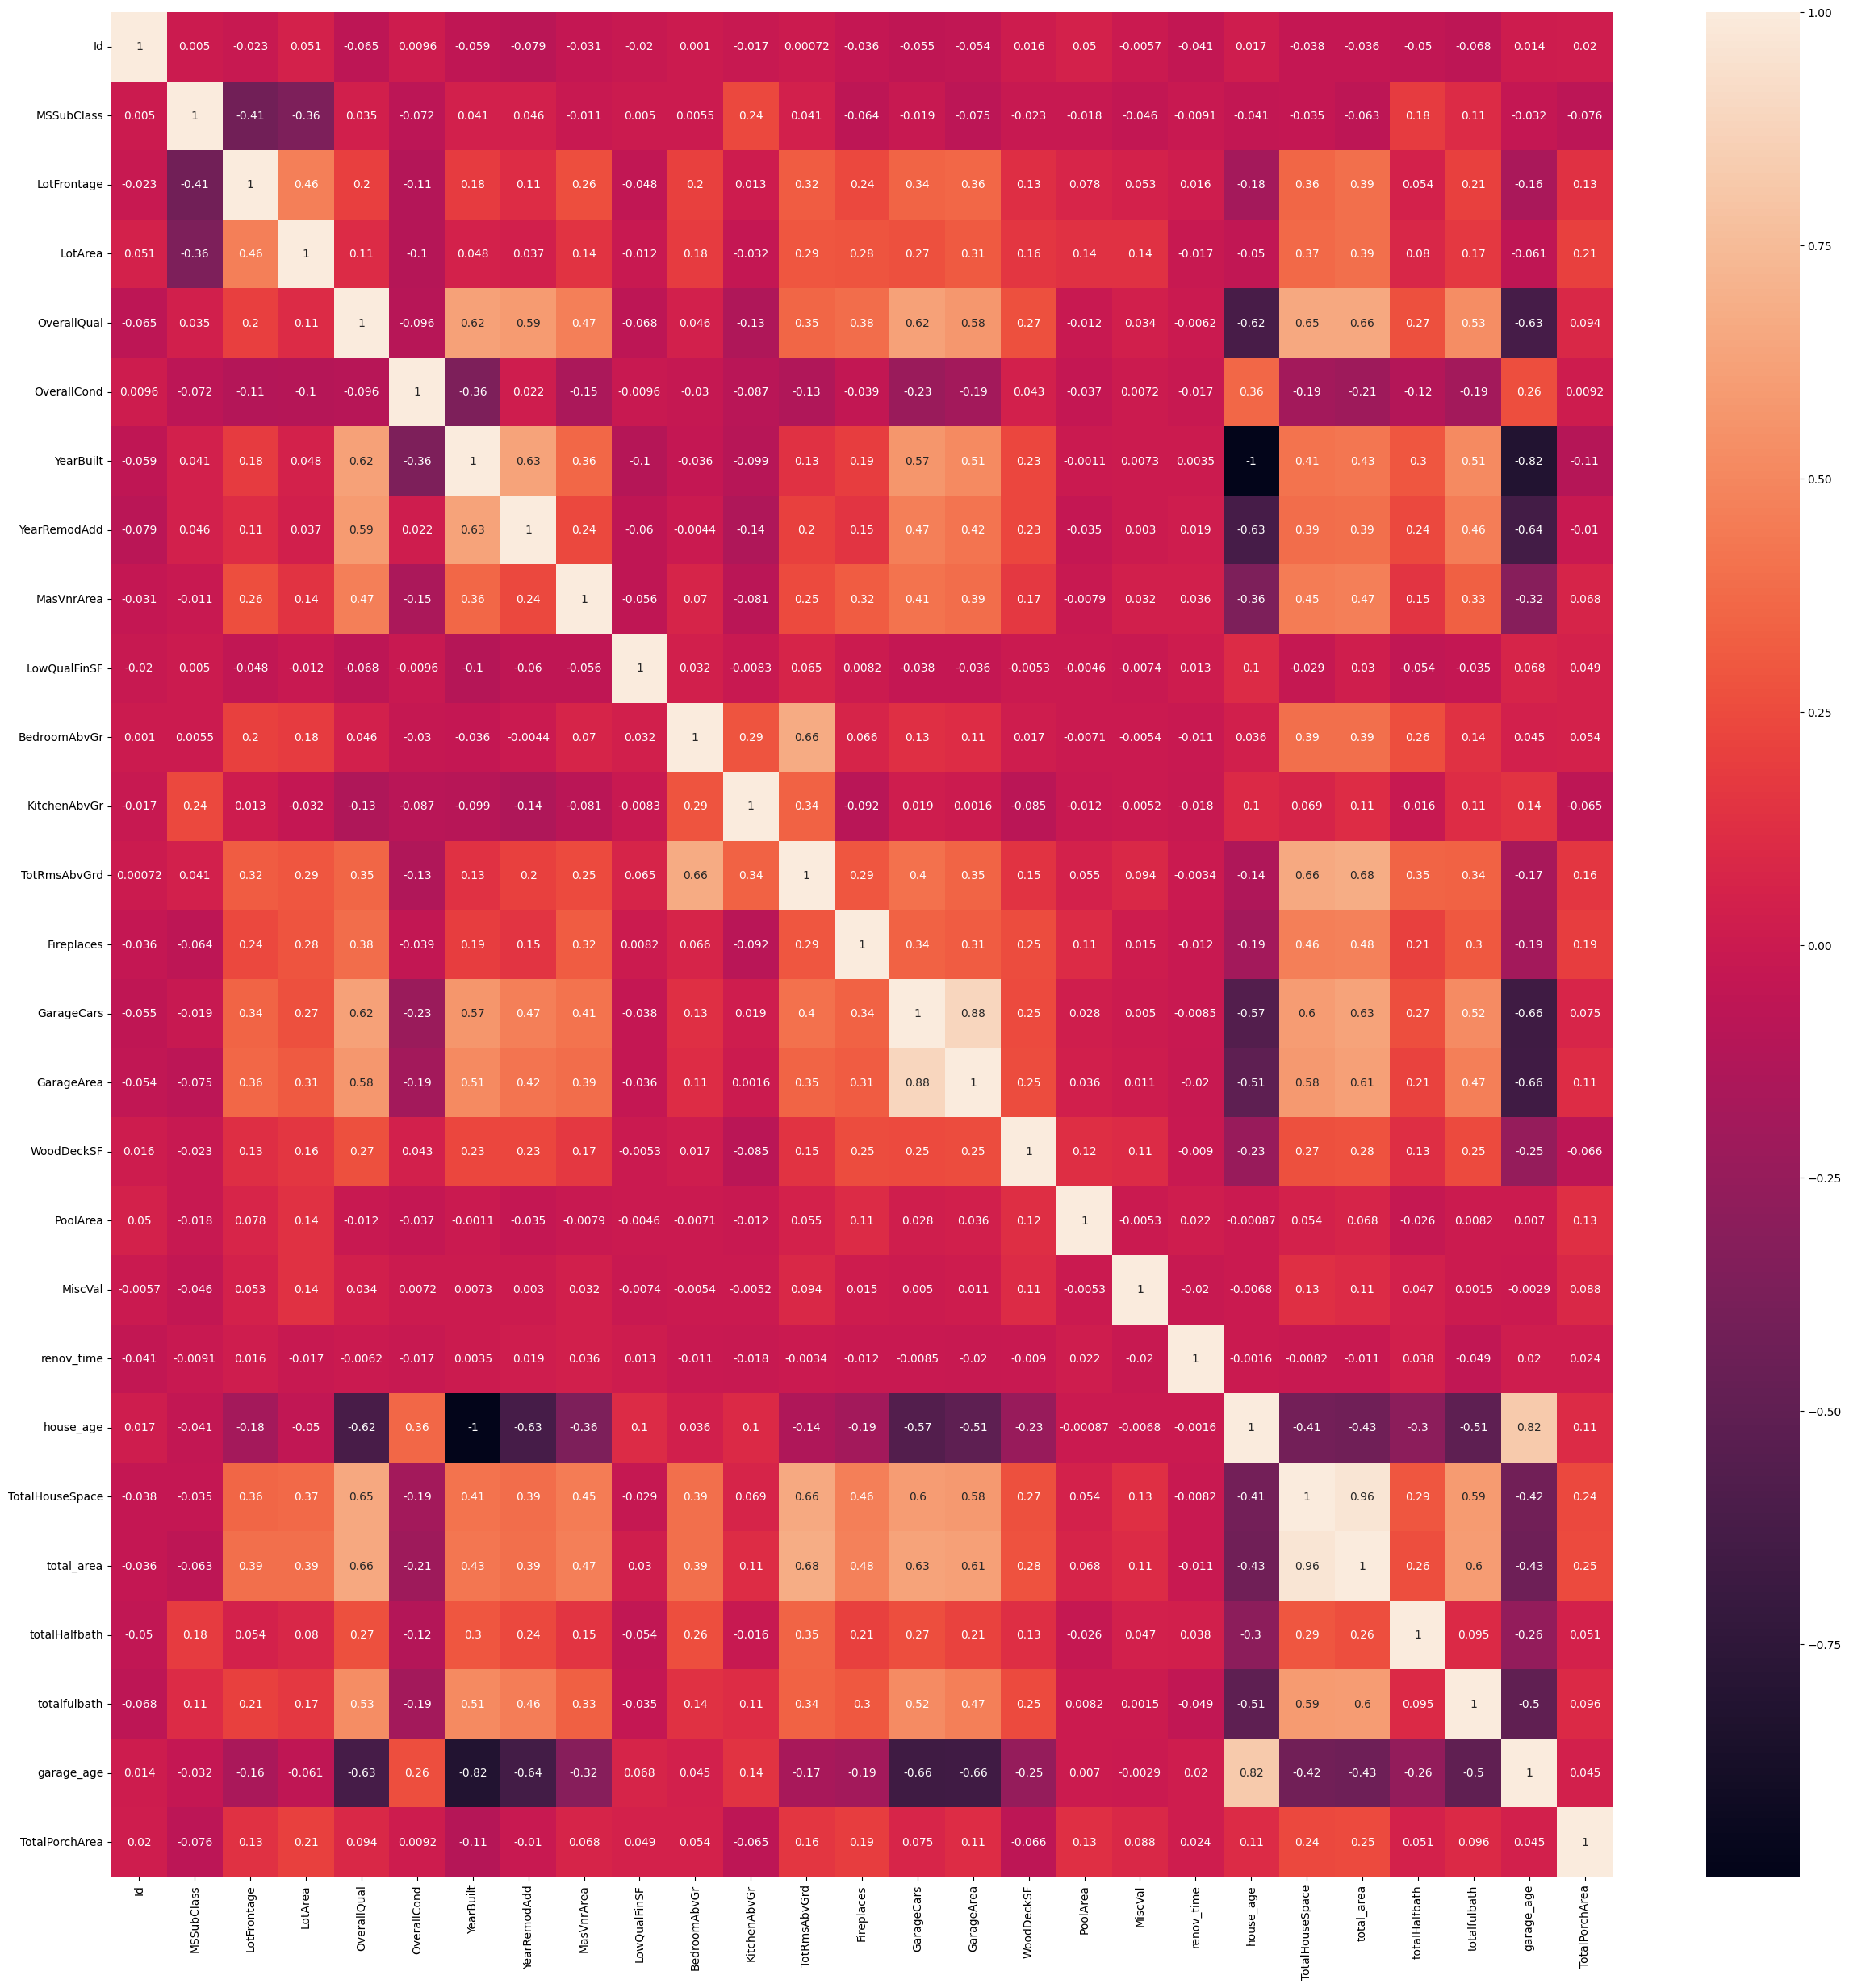

In [272]:
# Test data Correlation
corr_matrix_test=test_data.corr()
fig,ax=plt.subplots(figsize=(30,30))
sns.heatmap(corr_matrix_test,annot=True,ax=ax)

<Axes: >

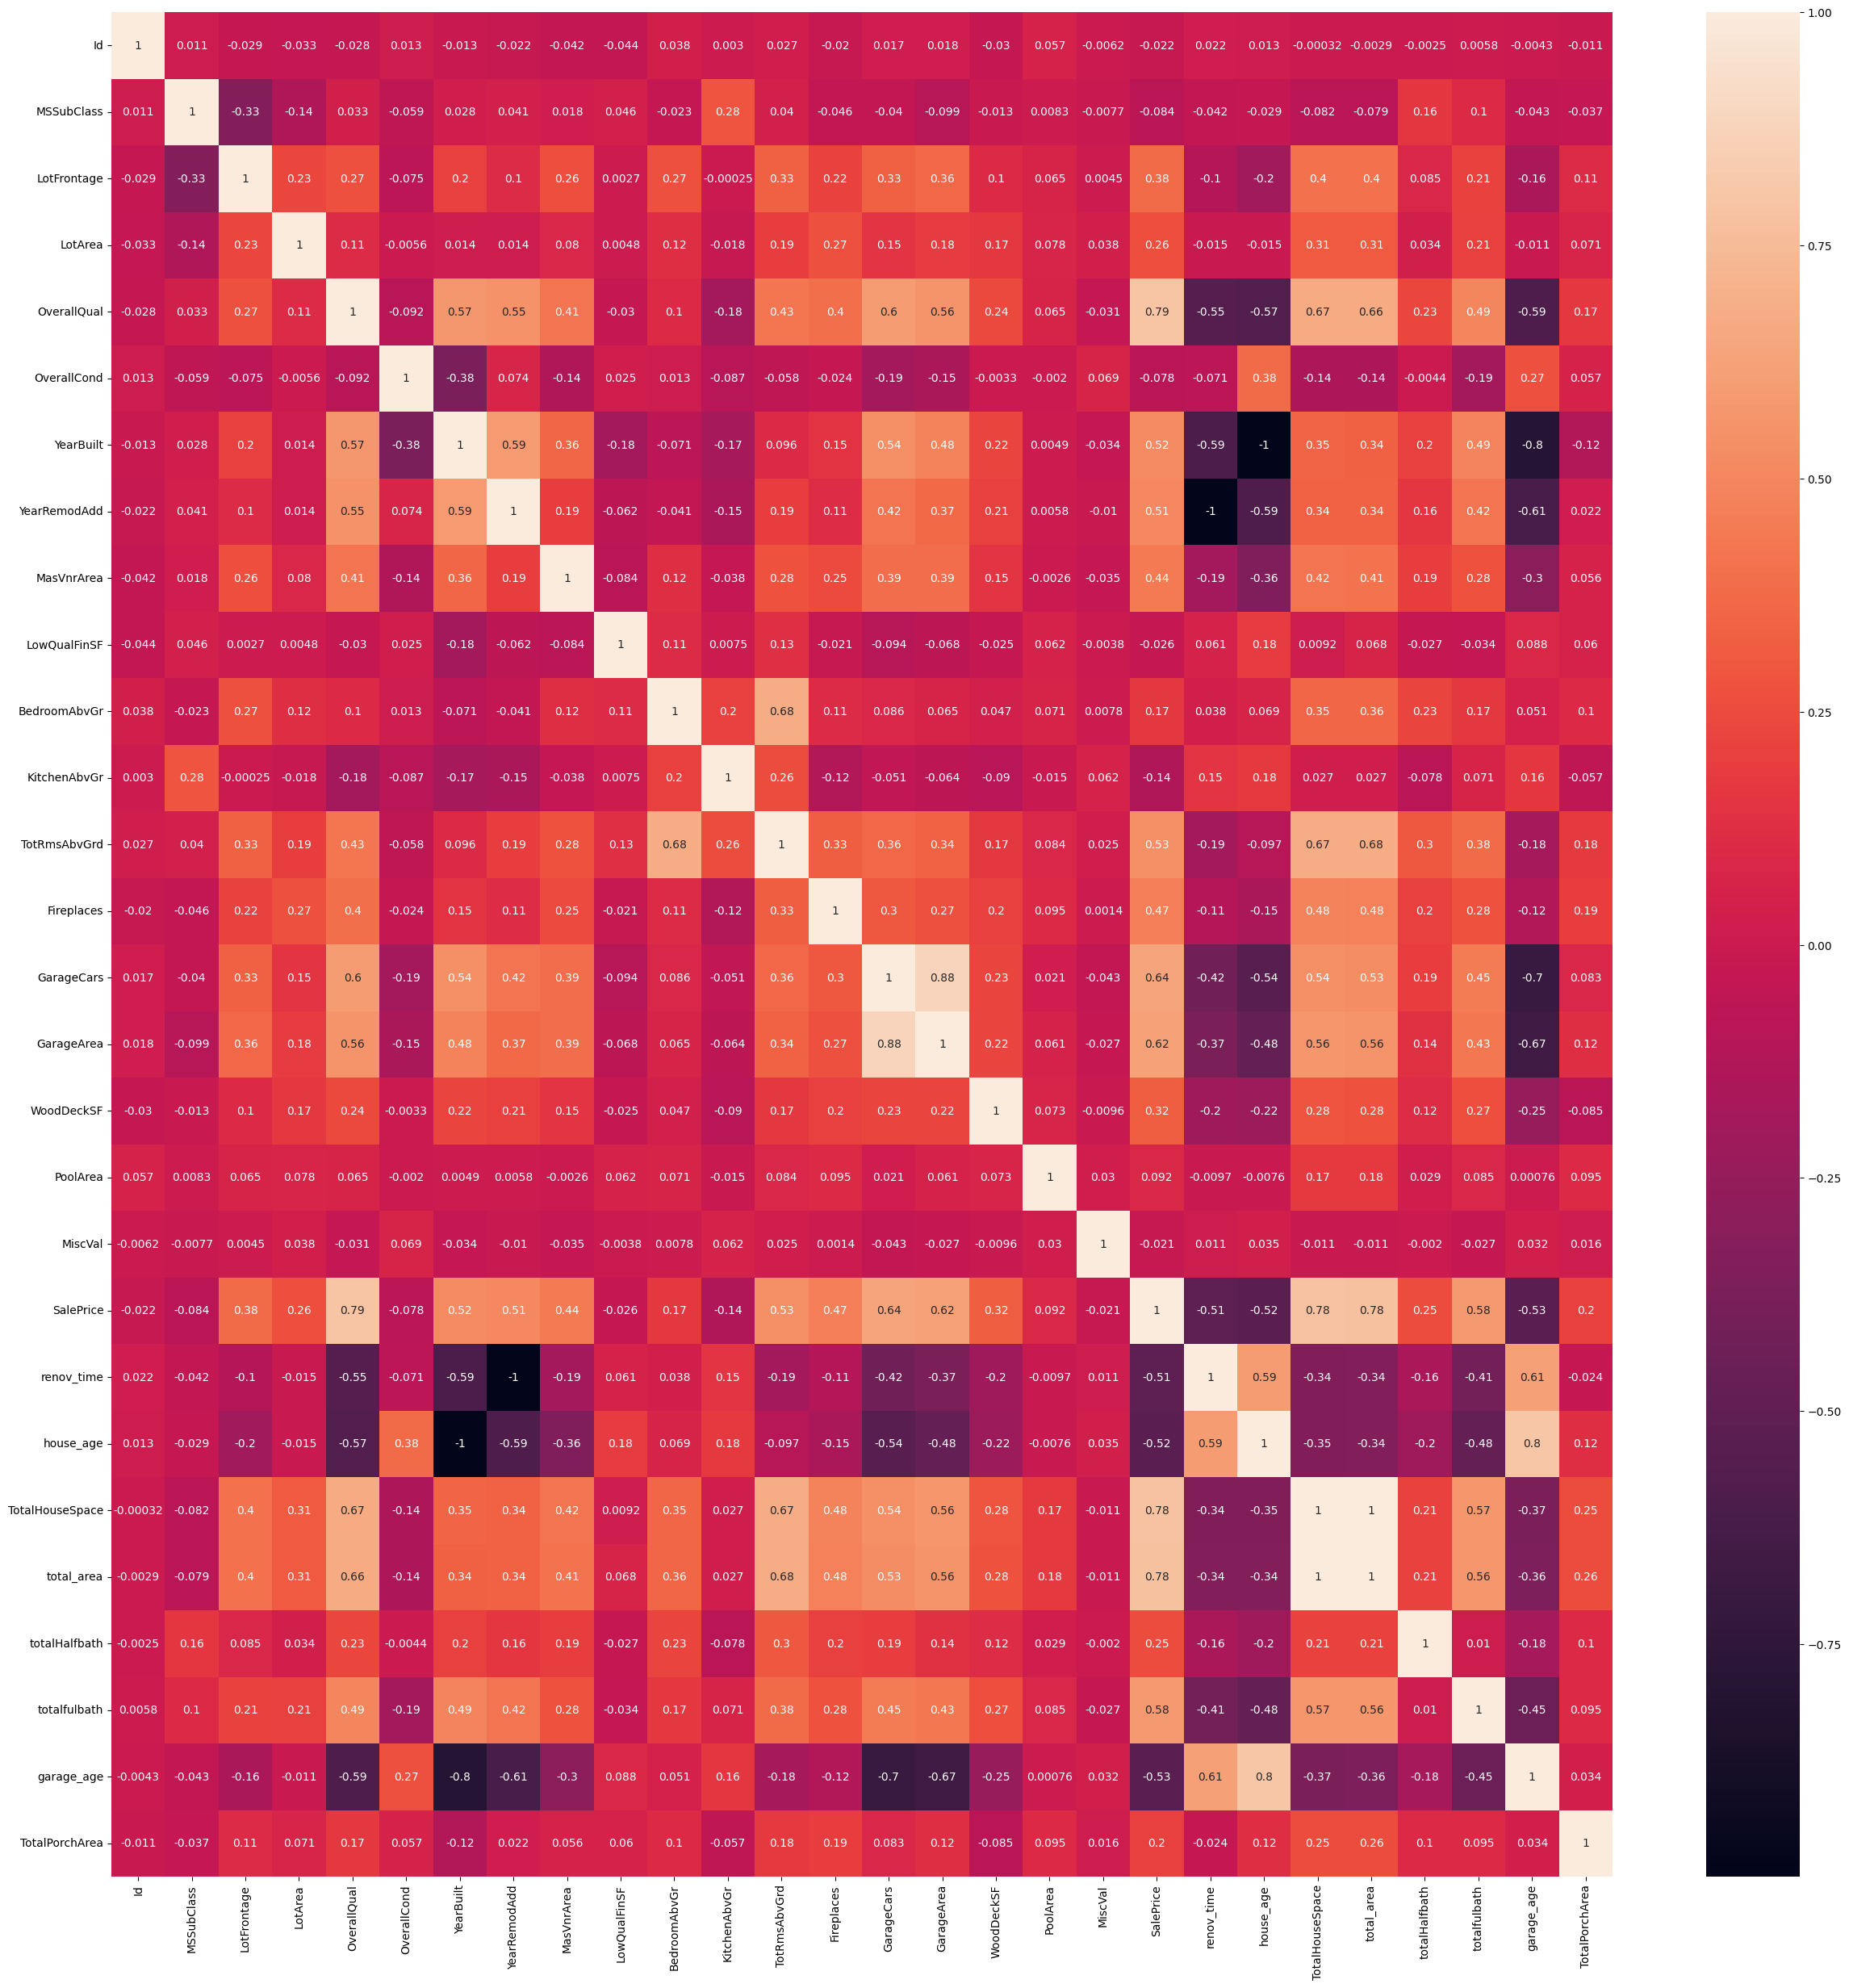

In [273]:
# Test data Correlation
corr_matrix_train=train_data.corr()
fig,ax=plt.subplots(figsize=(30,30))
sns.heatmap(corr_matrix_train,annot=True,ax=ax)

In [274]:
train_data=train_data.drop("GarageArea",axis=1)
test_data=test_data.drop("GarageArea",axis=1)

In [275]:
# for numeric transformation
num_col=train_data.select_dtypes(include=["float","int"]).columns.drop("Id")
num_col=num_col.drop("SalePrice")
# for ordinal encoder
cols_ordinal=["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","FireplaceQu","GarageQual","Fence"]
# for one hot encoding
one_hot_cols= [col for col in train_data.columns if (train_data[col].dtype == "object") & (col not in cols_ordinal)]

In [276]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

In [277]:
# create pipelines
# numeric cols pipeline
pipeline_nu=Pipeline(steps=
                    [
                        ("imp",SimpleImputer(strategy="median")),
                        ("ss",StandardScaler())
                    ])

In [278]:
# for ordinal categorical cols.
pipeline_ord=Pipeline(steps=[
            ("imp",SimpleImputer(strategy="most_frequent")),
            ("ore",OrdinalEncoder())
])

In [279]:
# for onehot categorical cols.
pipeline_oh=Pipeline(steps=[
            ("imp",SimpleImputer(strategy="most_frequent")),
            ("ore",OneHotEncoder())
])

In [280]:
cols_tr = ColumnTransformer(transformers = [
    ('nu_pt', pipeline_nu, num_col),
    ('ord_pt', pipeline_ord, cols_ordinal),
    ('oh_pt', pipeline_oh, one_hot_cols)
    ], 
    remainder = 'passthrough',
    n_jobs = -1)

In [281]:
pipe_tr = Pipeline(steps = [
    ('preprocessing', cols_tr)
])

In [282]:
X=train_data.drop(columns=["Id","SalePrice"],axis=1)
y=train_data["SalePrice"]

In [283]:
X_transformed=pipe_tr.fit_transform(X)

In [284]:
X_train,X_test,y_train,y_test=train_test_split(X_transformed,y,test_size=0.1,random_state=42)

In [285]:
# algorithms={
#     "linear_reg":{
#         "alg":LinearRegression(),
#         "param":{}
#     },
#     "ridge":{
#         "alg":Ridge(),
#         "param":{
#             "alpha":np.arange(0,1,0.1),
#             'solver' : ['auto','lsqr', 'sparse_cg', 'sag'] 
#             }
#     },
#     "gradient_b_r":{
#         "alg":GradientBoostingRegressor(),
#         "param":{
#             "n_estimators":[100,300,500],
#             "min_samples_leaf":[2,5,10,20],
#             "learning_rate":loguniform(0.01,1.0),
#             "max_depth":[10,15,20,25]
             
#         }
#     },
      
#      "LGBMRegressor":{
#         "alg":LGBMRegressor(),
#         "param":{
#              "n_estimators":[500,800,1000],
#             "learning_rate":[0.01,0.05,0.1],
             
#         }
#     },
#      "GBRegressor":{
#         "alg":XGBRegressor(),
#         "param":{
#             "n_estimators":[300,500,800,1000],
#             "learning_rate":[0.01,0.05,0.1],
#             "max_depth":[6,9,12,15]
#         }
#     },
    
# }

In [286]:
# best_score=list()
# best_param=list()
# alg_name=list()
# for name,algorithm in algorithms.items():
#      RS_cv=RandomizedSearchCV(algorithm["alg"],algorithm["param"],n_iter=10,cv=5)
#      RS_cv.fit(X_train,y_train)
#      best_score.append(RS_cv.best_score_)
#      best_param.append(RS_cv.best_params_)
#      alg_name.append(name)
    

# result=pd.DataFrame(
#     {
#         "alg_name":alg_name,
#         "best_score":best_score,
#         "best_param":best_param
#     }
# )
     

In [287]:
result

,alg_name,best_score,best_param
0,linear_reg,0.841446,{}
1,ridge,0.862315,"{'solver': 'sparse_cg', 'alpha': 0.9}"
2,gradient_b_r,0.884829,"{'learning_rate': 0.02447591413660872, 'max_de..."
3,LGBMRegressor,0.888320,"{'n_estimators': 800, 'learning_rate': 0.01}"
4,GBRegressor,0.874501,"{'n_estimators': 500, 'max_depth': 6, 'learnin..."


In [321]:
Stack=StackingRegressor(
    estimators=[
        ("lr",LinearRegression()),
        ("ridge",Ridge(solver= 'sparse_cg', alpha= 0.9)),
        ("Grad_b",GradientBoostingRegressor(learning_rate=0.02447591413660872,max_depth=25,min_samples_leaf= 20,n_estimators=500)),
        ("lgbm",LGBMRegressor(n_estimators= 800, learning_rate= 0.01)),
        ("xgb",XGBRegressor(n_estimators=500, max_depth= 6, learning_rate=0.01)),
        ("cat_b",CatBoostRegressor(subsample= 0.05, min_data_in_leaf= 35, learning_rate= 0.1, iterations=500, depth=4, colsample_bylevel= 0.08))
        
    ],
    final_estimator=CatBoostRegressor(subsample= 0.05, min_data_in_leaf= 35, learning_rate= 0.1, iterations=500, depth=4, colsample_bylevel= 0.08),
    passthrough=True
     
)

In [322]:
Stack.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 147
[LightGBM] [Info] Start training from score 12.025324
0:	learn: 0.3789761	total: 2.76ms	remaining: 1.38s
1:	learn: 0.3608582	total: 5.5ms	remaining: 1.37s
2:	learn: 0.3428609	total: 8.63ms	remaining: 1.43s
3:	learn: 0.3276871	total: 13.5ms	remaining: 1.67s
4:	learn: 0.3142730	total: 16ms	remaining: 1.58s
5:	learn: 0.2992251	total: 18.4ms	remaining: 1.52s
6:	learn: 0.2854671	total: 20.8ms	remaining: 1.46s
7:	learn: 0.2722893	total: 24.6ms	remaining: 1.51s
8:	learn: 0.2616665	total: 27.4ms	remaining: 1.5s
9:	learn: 0.2513283	total: 29.8ms	remaining: 1.46s
10:	learn: 0.2447553	total: 32ms	remaining: 1.42s
11:	learn: 0.2401488	total: 34.3ms	re

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('ridge', Ridge(alpha=0.9, solver='sparse_cg')),
                              ('Grad_b',
                               GradientBoostingRegressor(learning_rate=0.02447591413660872,
                                                         max_depth=25,
                                                         min_samples_leaf=20,
                                                         n_estimators=500)),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.01,
                                             n_estimators=800)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            co...
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('cat_b',
                               <catboost.core.CatBoostRegressor object at 0x00000269C3CDAD10>)],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x00000269C3CDB220>,
                  passthrough=True)

In [323]:
s_pred=Stack.predict(X_test)

In [324]:
mean_squared_error(y_test,s_pred)

0.013527332963324559

0.014529478874764341

In [325]:
est=[
    ("lr",LinearRegression()),
        ("ridge",Ridge(solver= 'sparse_cg', alpha= 0.9)),
        ("Grad_b",GradientBoostingRegressor(learning_rate=0.02447591413660872,max_depth=25,min_samples_leaf= 20,n_estimators=500)),
        ("lgbm",LGBMRegressor(n_estimators= 800, learning_rate= 0.01)),
        ("xgb",XGBRegressor(n_estimators=500, max_depth= 6, learning_rate=0.01)),
        ("cat_b",CatBoostRegressor(subsample= 0.05, min_data_in_leaf= 35, learning_rate= 0.1, iterations=500, depth=4, colsample_bylevel= 0.08))
        
]

In [326]:
voting_re=VotingRegressor(
    estimators=est
)

In [327]:
voting_re.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 147
[LightGBM] [Info] Start training from score 12.025324
0:	learn: 0.3789761	total: 2.61ms	remaining: 1.3s
1:	learn: 0.3608582	total: 5.53ms	remaining: 1.38s
2:	learn: 0.3428609	total: 8.34ms	remaining: 1.38s
3:	learn: 0.3276871	total: 12.9ms	remaining: 1.6s
4:	learn: 0.3142730	total: 15.3ms	remaining: 1.51s
5:	learn: 0.2992251	total: 17.6ms	remaining: 1.45s
6:	learn: 0.2854671	total: 19.7ms	remaining: 1.39s
7:	learn: 0.2722893	total: 21.8ms	remaining: 1.34s
8:	learn: 0.2616665	total: 24.9ms	remaining: 1.36s
9:	learn: 0.2513283	total: 27ms	remaining: 1.32s
10:	learn: 0.2447553	total: 29ms	remaining: 1.29s
11:	learn: 0.2401488	total: 31.2ms	re

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('ridge', Ridge(alpha=0.9, solver='sparse_cg')),
                            ('Grad_b',
                             GradientBoostingRegressor(learning_rate=0.02447591413660872,
                                                       max_depth=25,
                                                       min_samples_leaf=20,
                                                       n_estimators=500)),
                            ('lgbm',
                             LGBMRegressor(learning_rate=0.01,
                                           n_estimators=800)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          cols...
                                          learning_rate=0.01, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=6,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('cat_b',
                             <catboost.core.CatBoostRegressor object at 0x00000269C59074C0>)])

In [328]:
v_pred=voting_re.predict(X_test)

In [329]:
mean_squared_error(y_test,v_pred)

0.013163738260584819

In [330]:
test_data_n=test_data.drop("Id",axis=1)

In [331]:
test_transformed=pipe_tr.transform(test_data_n)

In [332]:
sub= np.exp(voting_re.predict(test_transformed))

In [333]:
submission=pd.DataFrame(
    {
        "Id":test_data.Id,
        "SalePrice":sub
    }
).set_index("Id")

In [334]:
submission.to_csv("submission.csv")